### TODO
* Read all files into the list
* Check it out
* Choose files one by one
     * get info: platform, channels, business units
     * 

In [1]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import scipy
import scipy.stats as stat
import xlsxwriter
from pathlib import Path

In [2]:
time_window_regr = 12 # number of weeks for regression

In [3]:
list_files = os.listdir("./input")
list_files

['4Camping.csv',
 '4home.csv',
 'aliatic.csv',
 'apotek.csv',
 'audiopartner.csv',
 'aurio.csv',
 'axa-assistance.csv',
 'bezvasport.csv',
 'bluestyle.csv',
 'brw.csv',
 'cocochocosk.csv',
 'CoolStuff.csv',
 'czechnutrition.csv',
 'decodoma.csv',
 'Econea.csv',
 'eyerim.csv',
 'FactCool.csv',
 'fitplus.csv',
 'hartman.csv',
 'hptronic.csv',
 'istepcesro.csv',
 'ketodiet.csv',
 'krmimkvalitne.csv',
 'muziker.csv',
 'nafigatecosmetics.csv',
 'packwaysro.csv',
 'selsey.csv',
 'semahead.csv',
 'skodaautodigilab.csv',
 'superbet.csv',
 'superzoo.csv',
 'upcsk.csv',
 'vemzu.csv',
 'vodafone.csv']

In [4]:
mypath = Path().absolute()
folder = 'output\\'
img_folder = folder + 'img\\'

In [5]:
folder

'output\\'

In [6]:
# execute for all files
for i in list_files:
    pass

include image if regression available
add only new lines if it need (different numbers for raw with images and blank lines 

In [8]:
# Data type description for dataset columns

DateTimeID = ['periodStartDate']

usecols = [
    "account",
    "adCampaign", "platformCode","currencyCode", "channelCode", "marketingInvestment",
    "impressions", "clicks", "visits", "conversions", "deliveries",
    "netRevenue", "grossProfit", "adGroup", "periodStartDate","businessUnit"
          ]

dtype = {
    'account': str,
    'adCampaign' : str,
    'platformCode' : str,
    'businessUnit':str,
    'currencyCode':str,
    'channelCode' : str,
    'impressions' : int,
    'clicks' : int,
    'visits' : int,
    'conversions' : int,
    'deliveries' : int,
    'netRevenue' : float,
    'grossProfit' : float,
    'adGroup' : str,
    'marketingInvestment': float
}

In [9]:
# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    function = log_f # it's bad staff #TODO
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = function(t_train, *parameterTuple)
    return np.sum((y_train - val) ** 2.0)

In [10]:
def select_agg_resample_df(df, index, granularity, use_nan):
    """Function for select and group  data in dataframe
    input: pandas dataframe, name of index, granularity['week','month'] default as in dataframe
    return: aggregated dataframe with extra column with indexes [ROI, CPI, CPC]"""
    group_df = df.groupby(['periodStartDate']).agg({
    'netRevenue': 'sum',
    'marketingInvestment': 'sum', 
    'visits': 'sum', 
    'conversions': 'sum',
    'deliveries': 'sum', 
    'impressions': 'sum', 
    'clicks': 'sum', 
    'grossProfit': 'sum' })   

    if granularity == 'week':
        group_agg_df = group_df.resample('W-MON').agg('sum')
    elif granularity == 'month':
        group_agg_df = group_df.resample('M', convention='end').agg('sum')
    elif granularity == 'day':
        group_agg_df = group_df
    else:
        raise ValueError("Incorrect aggregation period, shuld be 'day', 'week' or 'month'")

    if use_nan == False:
        group_agg_df.fillna(0)
    else:
        pass
    return group_agg_df

In [11]:
# function for search initial value for regression parameters
from scipy.optimize import differential_evolution
import warnings
def generate_Initial_Parameters(t_train, y_train,function):
    # min and max used for bounds
    maxX = max(t_train)
    minX = min(t_train)
    maxY = max(y_train)
    minY = min(y_train)
    maxXY = max(maxX, maxY)

    parameterBounds = []
    parameterBounds.append([-maxXY, maxXY]) # seach bounds for a
    parameterBounds.append([-maxXY, maxXY]) # seach bounds for b
    #parameterBounds.append([-maxXY, maxXY]) # seach bounds for c

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

In [12]:
def regression_calc(df, function):
    """Calculate paramiters of regression function
    input: pandas dataframe [x,y]
    output: list[paramiters], list[std diviation err of paramiters]"""
    from scipy.optimize import curve_fit
    t_train = df[df.columns[0]]  #
    y_train = df[df.columns[1]]
    geneticParameters = generate_Initial_Parameters(t_train, y_train, log_f)
    popt, pcov = curve_fit(log_f, t_train, y_train, geneticParameters)
    #popt, pcov = curve_fit(function, t_train, y_train)
    error  = np.sqrt(np.diag(pcov))
    return popt, error

In [13]:
def filter_df(df, alpha):
    return df.ewm(alpha=alpha, adjust=False).mean()

In [14]:
# regression functions definition
def log_f(x, a, b):
    return a * (1-np.exp(-x/b)) #a * (1 - np.exp((x/b)))

def line_f(x, a, b):
    return a * x + b

def sine_f(x, a, b):
    return a * np.sin(b * x)

In [15]:
def save_chart(sorted_df, name, R_std):
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.subplots_adjust(bottom=0.15, left=0.2)
    x = np.linspace(0,sorted_df['marketingInvestment'].max(),20)
    ax.scatter(sorted_df['marketingInvestment'], sorted_df['grossProfit'])
    ax.plot(x,log_f(x, *regr)- 2*R_std)
    ax.plot(x,log_f(x, *regr)+ 2*R_std)
    ax.plot(x,log_f(x, *regr))
    ax.set_xlabel(f'Investment {name[1]}')
    ax.set_ylabel(f'Profit {name[1]}')
    ax.set_title(name[0])
    plt.savefig( name[0] + '.jpg', dpi=150, pad_inches=0.1)  
    plt.close()
    #plt.show()


In [16]:
df = pd.read_csv('input\\'+ list_files[1],
                 sep="\t",
                 infer_datetime_format=True,
                 usecols=usecols,
                 dtype=dtype,
                 parse_dates=DateTimeID)

df['periodStartDate'] = pd.to_datetime(df['periodStartDate'])

df.head(5)

,account,businessUnit,platformCode,channelCode,adCampaign,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit,currencyCode,adGroup,periodStartDate
0,forhome,forhomecz,(direct),direct,NaN,0.0,0,0,988,33,33,25309.0,9617.42,CZK,NaN,2020-01-21
1,forhome,forhomecz,notset,referral,NaN,0.0,0,0,11,1,1,418.0,158.84,CZK,NaN,2020-01-21
2,forhome,forhomecz,notset,referral,NaN,0.0,0,0,12,0,0,0.0,0.00,CZK,NaN,2020-01-21
3,forhome,forhomecz,notset,referral,NaN,0.0,0,0,6,0,0,0.0,0.00,CZK,NaN,2020-01-21
4,forhome,forhomecz,notset,referral,NaN,0.0,0,0,1,0,0,0.0,0.00,CZK,NaN,2020-01-21


In [57]:
df.shape

(394472, 16)

In [58]:
#list_files[6]

In [59]:
platform_code = df['platformCode'].unique().tolist()
platform_code.sort()
business_unit_code = df['businessUnit'].unique().tolist()
business_unit_code.sort()
channel_code_code = df['channelCode'].unique().tolist()
channel_code_code.sort()
currency_code_code = df['currencyCode'].unique().tolist()
currency_code_code.sort()
account_code = df['account'].unique().tolist()



In [27]:
account_code

['forhome']

In [28]:
#select window for regression 
excel_coll = 0
precision = 3

workbook = xlsxwriter.Workbook( 'campaign_' + account_code[0]+'_corr.xlsx') #folder + 
bold = workbook.add_format({'bold': True})


df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

#df_time_selected = filter_df(df_time_selected, 0.1)

for i in business_unit_code:
    df_selected = df_time_selected[df_time_selected['businessUnit'] == i]
    worksheet = workbook.add_worksheet(i)
    
    worksheet.set_column('A:A', 30)
    worksheet.set_column('B:B', 10)
    worksheet.set_column('C:C', 15)
    worksheet.set_column('D:D', 15)
    worksheet.set_column('E:E', 15)
    worksheet.set_column('F:F', 15)
    worksheet.set_column('G:G', 40)

    worksheet.write('A1', 'Name', bold)
    worksheet.write('B1', 'Corr coeff.', bold)
    worksheet.write('C1', 'a', bold)
    worksheet.write('D1', 'b', bold)
    worksheet.write('E1', 'c', bold)
    worksheet.write('F1', 'R-std', bold)
    worksheet.write('G1', 'Chart', bold)
    
    excel_row  = 2
    
    for z in platform_code:
        df_platform = df_selected[df_selected['platformCode'] == z]
        df_business_selected_agg = select_agg_resample_df(df_platform, 'periodStartDate', 'week', use_nan = False)
        df_business_selected_agg = filter_df(df_business_selected_agg, 0.05)
        sper_crr, _=stat.spearmanr(df_business_selected_agg['marketingInvestment'], df_business_selected_agg['grossProfit'])
        if sper_crr> 0.75:
            print (i + ' business unit '+ z + ' platform has \t'+ str(sper_crr) + ' correlation coefficient')

            try:
                sorted_df = df_business_selected_agg.sort_values( by=['marketingInvestment'], ascending=False )
                t_train = sorted_df['marketingInvestment']
                y_train = sorted_df['grossProfit']
                
                regr, err = regression_calc(sorted_df[['marketingInvestment','grossProfit']],log_f)
                
                R = sorted_df['grossProfit'] - log_f(sorted_df['marketingInvestment'], *regr)
                R_std = R.describe()['std']
                
                ing_name = [i+z, currency_code_code]
                save_chart(sorted_df, ing_name, R_std)
                             
                a,b = regr
                #print(a,b,c)
                worksheet.write('A'+str(excel_row), z)
                worksheet.write('B'+str(excel_row), str(np.round(sper_crr, precision)))
                
                worksheet.write('C'+str(excel_row), str(np.round(a, precision)))
                worksheet.write('D'+str(excel_row), str(np.round(b, precision)))
                #worksheet.write('E'+str(excel_row), str(np.round(c, precision)))
                
                
                worksheet.write('F'+str(excel_row), str(np.round(R_std, precision)))
                
                worksheet.insert_image('G'+ str(excel_row), i + z + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
                
                excel_row = excel_row + 10
                print('Regression calculated successfully')
            except:
                print("Regression wasn't calculated")
                worksheet.write('A'+ str(excel_row), z)
                excel_row = excel_row + 1

        else:
            pass

workbook.close()

forhomecz business unit AdWords platform has 	0.967032967032967 correlation coefficient
Regression calculated successfully
forhomecz business unit Biano platform has 	1.0 correlation coefficient
Regression calculated successfully
forhomecz business unit DogNet platform has 	0.967032967032967 correlation coefficient
Regression calculated successfully
forhomecz business unit FacebookBusinessAdsManager platform has 	0.9725274725274725 correlation coefficient
Regression calculated successfully
forhomecz business unit Favi platform has 	0.9835164835164836 correlation coefficient
Regression calculated successfully
forhomecz business unit HeurekaCz platform has 	0.9835164835164836 correlation coefficient
Regression calculated successfully
forhomecz business unit RtbHouse platform has 	0.9945054945054945 correlation coefficient
Regression calculated successfully
forhomecz business unit Sklik platform has 	0.9945054945054945 correlation coefficient
Regression calculated successfully
forhomecz b

In [29]:
sper_corr, _ = stat.spearmanr(df_business_selected_agg['marketingInvestment'], df_business_selected_agg['grossProfit'])

In [33]:
df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

df_business_selected = df_time_selected[df_time_selected['businessUnit'] == 'forhomecz']

df_business_selected = df_business_selected[df_business_selected['platformCode'] == 'AdWords']

df_business_selected_agg = select_agg_resample_df(df_business_selected, 'periodStartDate', 'week', use_nan = False)

df_business_selected_agg_filtered = filter_df(df_business_selected_agg, 0.01)

sorted_df = df_business_selected_agg_filtered.sort_values( by=['marketingInvestment'], ascending=False )

t_train = sorted_df['marketingInvestment']

y_train = sorted_df['grossProfit']

try:
    regr, err = regression_calc(sorted_df[['marketingInvestment','grossProfit']],log_f)
except:
    print("Regression wasn't calculated")

#save_chart(sorted_df,['Hello','CZK'] )

In [37]:
from sklearn.svm import SVR

In [40]:
#model = SVR(kernel='poly')

In [41]:
#model.fit(t_train,y_train)

In [472]:
regr

array([28421.02059206,  5191.6475058 ,  1961.10326005])

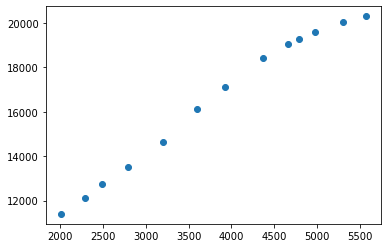

In [473]:
plt.scatter(sorted_df['marketingInvestment'], sorted_df['grossProfit'])

In [474]:
regr

array([28421.02059206,  5191.6475058 ,  1961.10326005])

In [475]:
R = sorted_df['grossProfit'] - log_f(sorted_df['marketingInvestment'], *regr)

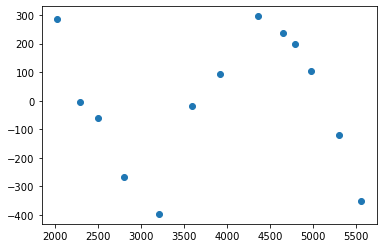

In [476]:
plt.scatter(sorted_df['marketingInvestment'], R)

In [483]:
R.describe()['std']

233.5728188679163

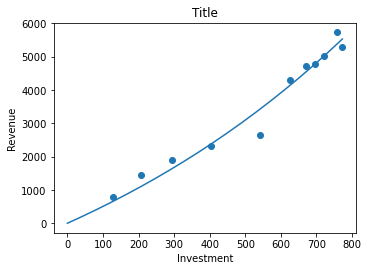

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.subplots_adjust(bottom=0.15, left=0.2)
x = np.linspace(0,sorted_df['marketingInvestment'].max(),20)
ax.scatter(sorted_df['marketingInvestment'], sorted_df['grossProfit'])
ax.plot(x,log_f(x, *regr))
ax.set_xlabel(f'Investment')
ax.set_ylabel(f'Revenue')
ax.set_title('Title')
#plt.savefig( name[0] + '.jpg', dpi=150, pad_inches=0.1)  
#plt.close()
plt.show()

In [24]:
sorted_df['netRevenue'].describe()[1]

26629.264751216742

In [428]:
R.describe()[2]

20450.413334746103

In [ ]:
statistics_R2 = []

statistics_R2.append(np.concatenate((regr, err), axis=0))

statistics_R2_df = pd.DataFrame(statistics_R2, columns = regr_name)

statistics_R2_df = statistics_R2_df.set_index([pd.Index(platform_code)])

In [63]:
df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

df_business_selected = df_time_selected[df_time_selected['businessUnit'] == 'forhomecz']

df_business_selected = df_business_selected[df_business_selected['platformCode'] == 'AdWords']

ad_campaign_code = df['adCampaign'].unique().tolist()
#campaign_code.sort()

#campaign_code

In [191]:
df = pd.read_csv('input\\'+ list_files[33],
                 sep="\t",
                 infer_datetime_format=True,
                 usecols=usecols,
                 dtype=dtype,
                 parse_dates=DateTimeID)

df['periodStartDate'] = pd.to_datetime(df['periodStartDate'])

df.head(5)

,account,businessUnit,platformCode,channelCode,adCampaign,marketingInvestment,impressions,clicks,visits,conversions,deliveries,netRevenue,grossProfit,currencyCode,adGroup,periodStartDate
0,vodafoneczechrepublicas,vodafonecz-leady,unpaid,notset,NaN,0.0,0,0,0,0,0,0.0,0.0,CZK,-,2020-01-23
1,vodafoneczechrepublicas,vodafonecz-leady,unpaid,direct,NaN,0.0,0,0,0,11,11,0.0,0.0,CZK,-,2020-01-23
2,vodafoneczechrepublicas,vodafonecz-leady,unpaid,email,NaN,0.0,0,0,0,0,0,0.0,0.0,CZK,-,2020-01-23
3,vodafoneczechrepublicas,vodafonecz-leady,unpaid,internal,NaN,0.0,0,0,0,0,0,0.0,0.0,CZK,-,2020-01-23
4,vodafoneczechrepublicas,vodafonecz-leady,AdWords,naturalsearch-google,NaN,0.0,0,0,18864,8,8,0.0,0.0,CZK,-,2020-01-23


In [192]:
platform_code = df['platformCode'].unique().tolist()
platform_code.sort()
business_unit_code = df['businessUnit'].unique().tolist()
business_unit_code.sort()
channel_code_code = df['channelCode'].unique().tolist()
channel_code_code.sort()
currency_code_code = df['currencyCode'].unique().tolist()
currency_code_code.sort()
account_code = df['account'].unique().tolist()


In [193]:
#select window for regression 
excel_coll = 0
precision = 3

workbook = xlsxwriter.Workbook(folder + account_code[0]+' Add campaign corr.xlsx') #folder + 
bold = workbook.add_format({'bold': True})


df_time_selected = df[df['periodStartDate'] >= df['periodStartDate'].max() - pd.DateOffset(weeks=time_window_regr)] 

#df_time_selected = filter_df(df_time_selected, 0.1)

worksheet = workbook.add_worksheet('Campaign')

excel_row  = 2

for i in business_unit_code:
    df_selected = df_time_selected[df_time_selected['businessUnit'] == i]
    #worksheet = workbook.add_worksheet(i)
    worksheet.set_column('A:A', 20)
    worksheet.set_column('B:B', 20)
    worksheet.set_column('C:C', 30)
    worksheet.set_column('D:D', 40)
    worksheet.set_column('E:E', 10)
    worksheet.set_column('F:F', 10)
    worksheet.set_column('G:G', 15)
    worksheet.set_column('H:H', 15)
    worksheet.set_column('I:I', 15)
    worksheet.set_column('J:J', 15)
    worksheet.set_column('K:K', 40)

    worksheet.write('A1', 'Client', bold)
    worksheet.write('B1', 'Business unit', bold)
    worksheet.write('C1', 'Platform', bold)
    worksheet.write('D1', 'Campaign', bold)
    worksheet.write('E1', 'Corr coeff.', bold)
    worksheet.write('F1', 'Pr. value', bold)
    worksheet.write('G1', 'a', bold)
    worksheet.write('H1', 'b', bold)
    worksheet.write('I1', 'Mean', bold)
    worksheet.write('J1', 'R-std', bold)
    worksheet.write('K1', 'Chart', bold)
    
    
    
    worksheet.write('A'+str(excel_row),i)
    
    for z in platform_code:
        df_platform = df_selected[df_selected['platformCode'] == z]
        
        ad_campaign_code = df_platform['adCampaign'].unique().tolist()
        
        for y in ad_campaign_code:
            
            df_platform = df_selected[df_selected['adCampaign'] == y]
                
            df_business_selected_agg = select_agg_resample_df(df_platform, 'periodStartDate', 'week', use_nan = False)
            df_business_selected_agg = filter_df(df_business_selected_agg, 0.2)
            
        
            sper_crr, P_value = stat.spearmanr(df_business_selected_agg['marketingInvestment'],                       df_business_selected_agg['grossProfit'])
            if sper_crr> 0.9:
                print (y + ' Add campaign' + i + ' business unit '+ z + ' platform has \t'+ str(sper_crr) + ' corr coefficient')

                try:
                    sorted_df = df_business_selected_agg.sort_values( by=['marketingInvestment'], ascending=False )
                    t_train = sorted_df['marketingInvestment']
                    y_train = sorted_df['grossProfit']
                
                    regr, err = regression_calc(sorted_df[['marketingInvestment','grossProfit']],log_f)
                
                    R = sorted_df['grossProfit'] - log_f(sorted_df['marketingInvestment'], *regr)
                    R_std = R.describe()['std']
                    
                    Y_mean = sorted_df['grossProfit'].describe()[1]
                    
                    ing_name = [y + i + z, currency_code_code]
                    save_chart(sorted_df, ing_name, R_std)
                             
                    a,b = regr
                    #print(a,b,c)
                    worksheet.write('A'+str(excel_row),account_code[0])
                    
                    worksheet.write('B'+str(excel_row),i)
                    
                    worksheet.write('C'+str(excel_row), z)
                    
                    worksheet.write('D'+str(excel_row), y)
                    
                    worksheet.write('E'+str(excel_row), str(np.round(sper_crr, precision)))
                    
                    worksheet.write('F'+str(excel_row), str(np.round(P_value, 7)))
                
                    worksheet.write('G'+str(excel_row), str(np.round(a, precision)))
                    
                    worksheet.write('H'+str(excel_row), str(np.round(b, precision)))                
                
                    worksheet.write('I'+str(excel_row), str(np.round(Y_mean, precision)))
                    
                    worksheet.write('J'+str(excel_row), str(np.round(R_std, precision)))
                
                    worksheet.insert_image('K'+ str(excel_row), y + i + z + '.jpg', {'x_scale': 0.5, 'y_scale': 0.5})
                
                    excel_row = excel_row + 10
                    print('Regression calculated successfully')
                except:
                    print("Regression wasn't calculated")
                   # worksheet.write('A'+ str(excel_row), z)
                   # excel_row = excel_row + 1

            else:
                pass

workbook.close()